In [1]:
#import modules
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from wordcloud import WordCloud, STOPWORDS

#create Spark session
appName = "Sentiment Analysis in Spark"
spark = SparkSession \
    .builder \
    .appName(appName) \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

23/10/16 19:40:38 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
#baca data set dengan skema yang tersedia pada dataset
#file datasetnya 'siap_review.csv' (silahkan disesuaikan dengan data set masing-masing)
review_csv = spark.read.csv('traveloka_review.csv', inferSchema=True, header=True)
review_csv.show(truncate=True, n=3)

23/10/16 19:40:53 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , reviewId, userName, userImage, content, score, thumbsUpCount, reviewCreatedVersion, at, replyContent, repliedAt
 Schema: _c0, reviewId, userName, userImage, content, score, thumbsUpCount, reviewCreatedVersion, at, replyContent, repliedAt
Expected: _c0 but found: 
CSV file: file:///Volumes/Data/MyJobs/Perangkat%20Ajar/20231/Big%20Data/Code/Sentiment%20Analysis/traveloka_review.csv
+---+--------------------+--------------------+--------------------+--------------------+-----+-------------+--------------------+-------------------+--------------------+-------------------+
|_c0|            reviewId|            userName|           userImage|             content|score|thumbsUpCount|reviewCreatedVersion|                 at|        replyContent|          repliedAt|
+---+--------------------+--------------------+--------------------+--------------------+-----+-------------+--------------------+--------

In [3]:
#pilih hanya kolom content dan score, 
#kasting kolom score menjadi bertipe int
review = review_csv.select(col("content").alias("Review"), \
                           col("at").cast("Date").alias("date"),\
                           col("score").cast("Int").alias("Score"))
review.show(truncate = True,n=5)
review.printSchema()

+--------------------+----------+-----+
|              Review|      date|Score|
+--------------------+----------+-----+
|                nice|2022-11-30|    5|
|Pelayanan yg baik...|2022-11-30|    5|
|sangat mudah untu...|2022-11-30|    5|
|Baru kali ini sy ...|2022-11-30|    1|
|mantap n cepat pr...|2022-11-30|    5|
+--------------------+----------+-----+
only showing top 5 rows

root
 |-- Review: string (nullable = true)
 |-- date: date (nullable = true)
 |-- Score: integer (nullable = true)



In [4]:
#Mengetahui jumlah baris 
jumlah_baris_keseluruhan = review.count()
jumlah_baris_null = jumlah_baris_keseluruhan - review.dropna().count()
jumlah_baris = jumlah_baris_keseluruhan-jumlah_baris_null
print("Jumlah baris keseluruhan : ",jumlah_baris_keseluruhan)
print("Jumlah baris null : ", jumlah_baris_null)
print("Jumlah sisa baris : ", jumlah_baris)

Jumlah baris keseluruhan :  166949
Jumlah baris null :  4038
Jumlah sisa baris :  162911


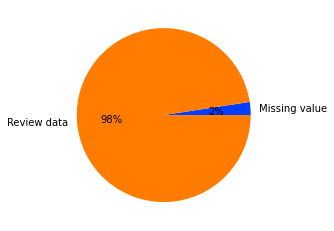

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

#Plot data ke pie chart
data = [jumlah_baris_null, jumlah_baris]
keys = ['Missing value', 'Review data']
palette_color = sns.color_palette('bright')
  
plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
plt.show()

In [11]:
#sorting data untuk mengetahui range tanggal review user
review = review.dropna()
review.sort(desc("date")).show()

+--------------------+----------+-----+
|              Review|      date|Score|
+--------------------+----------+-----+
|                nice|2022-11-30|    5|
|Pelayanan yg baik...|2022-11-30|    5|
|sangat mudah untu...|2022-11-30|    5|
|Baru kali ini sy ...|2022-11-30|    1|
|mantap n cepat pr...|2022-11-30|    5|
|             terbaik|2022-11-30|    5|
|cepat dan terpercaya|2022-11-30|    5|
|            Mantappp|2022-11-30|    5|
|                best|2022-11-30|    4|
|             ok brow|2022-11-30|    5|
|harga yg tertera ...|2022-11-30|    3|
|love you bgt sama...|2022-11-30|    5|
|    sangat membantu.|2022-11-30|    5|
|SAYA KECEWA DENGA...|2022-11-30|    1|
|              mantap|2022-11-30|    5|
|               bagus|2022-11-30|    5|
|                puas|2022-11-30|    5|
|mau bayar lunas m...|2022-11-30|    3|
|               bagus|2022-11-30|    5|
|Harga tiket dari ...|2022-11-30|    4|
+--------------------+----------+-----+
only showing top 20 rows



In [6]:
#jumlah data berdasarkan tahun
review_year = review.groupBy(year('date').alias('tahun'))\
               .agg(count('Score').alias('jumlah_review'))
review_year.sort(desc('tahun')).show()

+-----+-------------+
|tahun|jumlah_review|
+-----+-------------+
| 2022|        21437|
| 2021|        21883|
| 2020|        30336|
| 2019|        21310|
| 2018|        14682|
| 2017|        20299|
| 2016|        20856|
| 2015|        11454|
| 2014|          712|
| null|            4|
+-----+-------------+



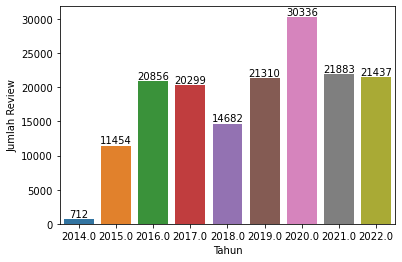

In [7]:
#menampilkan grafik data pertahun
import seaborn as sns
import matplotlib.pyplot as plt

pd_review = review_year.toPandas()
ax = sns.barplot(x = 'tahun',
            y = 'jumlah_review',
            data = pd_review)
ax.bar_label(ax.containers[0])
 
plt.xlabel("Tahun")
plt.ylabel("Jumlah Review")
plt.show()

In [37]:
#Filter data content yang kosong
data = review.filter(review.Review != "")
data.show()

+--------------------+----------+-----+
|              Review|      date|Score|
+--------------------+----------+-----+
|                nice|2022-11-30|    5|
|Pelayanan yg baik...|2022-11-30|    5|
|sangat mudah untu...|2022-11-30|    5|
|Baru kali ini sy ...|2022-11-30|    1|
|mantap n cepat pr...|2022-11-30|    5|
|             terbaik|2022-11-30|    5|
|cepat dan terpercaya|2022-11-30|    5|
|            Mantappp|2022-11-30|    5|
|                best|2022-11-30|    4|
|             ok brow|2022-11-30|    5|
|harga yg tertera ...|2022-11-30|    3|
|love you bgt sama...|2022-11-30|    5|
|    sangat membantu.|2022-11-30|    5|
|SAYA KECEWA DENGA...|2022-11-30|    1|
|              mantap|2022-11-30|    5|
|               bagus|2022-11-30|    5|
|                puas|2022-11-30|    5|
|mau bayar lunas m...|2022-11-30|    3|
|               bagus|2022-11-30|    5|
|Harga tiket dari ...|2022-11-30|    4|
+--------------------+----------+-----+
only showing top 20 rows



In [25]:
#Data preprocessing

#pilih data socre 1, 2, 4, dan 5
data = review.filter(review.Score != 3)
#membuat label berdasarkan score
# Score < 3 labelnya 0 --> Negatif
# Score > 3 labelnya 1 --> Positif
data = review.withColumn("label", when(review.Score < 3, 0).otherwise(1))
data.show()

+--------------------+----------+-----+-----+
|              Review|      date|Score|label|
+--------------------+----------+-----+-----+
|                nice|2022-11-30|    5|    1|
|Pelayanan yg baik...|2022-11-30|    5|    1|
|sangat mudah untu...|2022-11-30|    5|    1|
|Baru kali ini sy ...|2022-11-30|    1|    0|
|mantap n cepat pr...|2022-11-30|    5|    1|
|             terbaik|2022-11-30|    5|    1|
|cepat dan terpercaya|2022-11-30|    5|    1|
|            Mantappp|2022-11-30|    5|    1|
|                best|2022-11-30|    4|    1|
|             ok brow|2022-11-30|    5|    1|
|harga yg tertera ...|2022-11-30|    3|    1|
|love you bgt sama...|2022-11-30|    5|    1|
|    sangat membantu.|2022-11-30|    5|    1|
|SAYA KECEWA DENGA...|2022-11-30|    1|    0|
|              mantap|2022-11-30|    5|    1|
|               bagus|2022-11-30|    5|    1|
|                puas|2022-11-30|    5|    1|
|mau bayar lunas m...|2022-11-30|    3|    1|
|               bagus|2022-11-30| 

In [26]:
#jumlah data berdasarkan label/sentimen
review_sentimen = data.groupBy('label')\
    .agg(count('Score').alias('jumlah_review'))
review_sentimen.show()

+-----+-------------+
|label|jumlah_review|
+-----+-------------+
|    1|       144043|
|    0|        18868|
+-----+-------------+



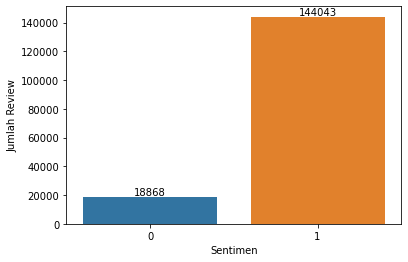

In [27]:
#menampilkan grafik sentimen
import seaborn as sns
import matplotlib.pyplot as plt

pd_sentimen = review_sentimen.toPandas()
ax = sns.barplot(x = 'label',
            y = 'jumlah_review',
            data = pd_sentimen)
ax.bar_label(ax.containers[0])
 
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Review")
plt.show()

In [32]:
#Cleaning data
#Menghapus tanda "
data = data.withColumn('Review', regexp_replace('Review',r"""[!\"#$%&'()*+,\-.\/:;<=>?@\[\\\]^_`{|}~]""",''))
#Menghapus missing value
data = data.dropna()
#data.collect()
data.show()

+--------------------+----------+-----+-----+
|              Review|      date|Score|label|
+--------------------+----------+-----+-----+
|                nice|2022-11-30|    5|    1|
|Pelayanan yg baik...|2022-11-30|    5|    1|
|sangat mudah untu...|2022-11-30|    5|    1|
|Baru kali ini sy ...|2022-11-30|    1|    0|
|mantap n cepat pr...|2022-11-30|    5|    1|
|             terbaik|2022-11-30|    5|    1|
|cepat dan terpercaya|2022-11-30|    5|    1|
|            Mantappp|2022-11-30|    5|    1|
|                best|2022-11-30|    4|    1|
|             ok brow|2022-11-30|    5|    1|
|harga yg tertera ...|2022-11-30|    3|    1|
|love you bgt sama...|2022-11-30|    5|    1|
|     sangat membantu|2022-11-30|    5|    1|
|SAYA KECEWA DENGA...|2022-11-30|    1|    0|
|              mantap|2022-11-30|    5|    1|
|               bagus|2022-11-30|    5|    1|
|                puas|2022-11-30|    5|    1|
|mau bayar lunas m...|2022-11-30|    3|    1|
|               bagus|2022-11-30| 

In [11]:
#install library wordcloud
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


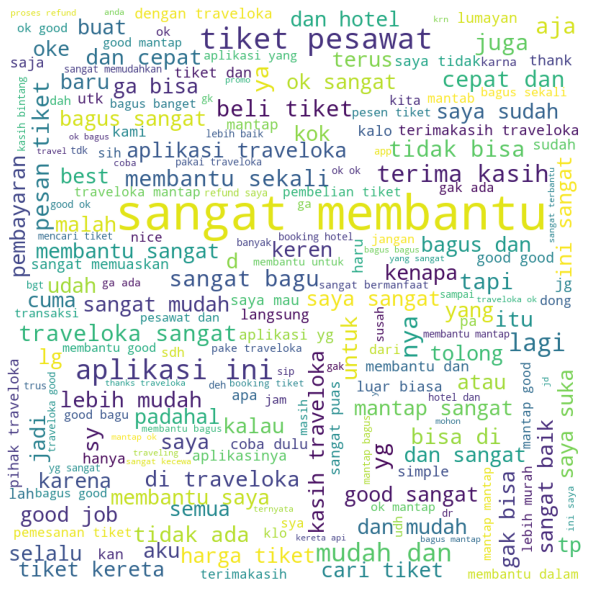

In [29]:
#Membuat wordcloud dari data review
import matplotlib.pyplot as plt
review_words = ''
stopwords = set(STOPWORDS)

df = data.toPandas()

# iterate through the csv file
for val in df.Review:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    review_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(review_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [30]:
#Membagi data, 70% untuk training, 30% untuk testing
dividedData = data.randomSplit([0.7, 0.3]) 
trainingData = dividedData[0] #index 0 = data training
testingData = dividedData[1] #index 1 = data testing
train_rows = trainingData.count()
test_rows = testingData.count()
print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)

Training data rows: 114068 ; Testing data rows: 48843


In [31]:
#Tokenisasi data / memisahkan kaliman menjadi per kata 
#dan dimasukan ke kolom SentimentWords
tokenizer = Tokenizer(inputCol="Review", outputCol="SentimentWords")
tokenizedTrain = tokenizer.transform(trainingData)
tokenizedTrain.show(truncate=True, n=5)

+--------------------+----------+-----+-----+--------------------+
|              Review|      date|Score|label|      SentimentWords|
+--------------------+----------+-----+-----+--------------------+
|                    |2021-09-10|    5|    1|                  []|
|                    |2021-10-06|    3|    1|                  []|
|                    |2021-11-13|    1|    0|                  []|
|                    |2022-04-07|    5|    1|                  []|
|     u    t Gf   ...|2022-05-25|    4|    1|[, , , , , u, , ,...|
+--------------------+----------+-----+-----+--------------------+
only showing top 5 rows



In [20]:
#Menghapus stopword (kata-kata yang tidak ada maknanya)
#hasilnya dimasukan ke kolom MeaningfulWords
stop = ['&7ûTTS','#ok','cmf','&7ûtts','(?','(Before)','(before)',' ','aa','aaqaa','sszy','gk','7sttc','y66s','i','am5','5','555','5v','hmm','u','9']
swr = StopWordsRemover(stopWords=stop, inputCol=tokenizer.getOutputCol(), 
                       outputCol="MeaningfulWords")
SwRemovedTrain = swr.transform(tokenizedTrain)

SwRemovedTrain = SwRemovedTrain.dropna()

SwRemovedTrain.show(truncate=True, n=5)

22/12/13 14:43:18 WARN StopWordsRemover: Default locale set was [en_ID]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
+--------------------+----------+-----+-----+--------------------+--------------------+
|              Review|      date|Score|label|      SentimentWords|     MeaningfulWords|
+--------------------+----------+-----+-----+--------------------+--------------------+
|                    |2021-09-10|    5|    1|                  []|                  []|
|                    |2021-10-06|    3|    1|                  []|                  []|
|                    |2021-11-13|    1|    0|                  []|                  []|
|                    |2022-04-07|    5|    1|                  []|                  []|
|     u    t Gf   ...|2022-05-25|    4|    1|[, , , , , u, , ,...|[, , , , , , , , ...|
+--------------------+----------+-----+-----+--------------------+-----------------

In [21]:
#Merubah fitur kata menjadi numerik dan hasilnya dimasukan ke kolom features
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numericTrainData = hashTF.transform(SwRemovedTrain).select(
    'label', 'MeaningfulWords', 'features')
numericTrainData.show(truncate=True, n=10)

+-----+--------------------+--------------------+
|label|     MeaningfulWords|            features|
+-----+--------------------+--------------------+
|    1|                  []|      (262144,[],[])|
|    1|                  []|      (262144,[],[])|
|    0|                  []|      (262144,[],[])|
|    1|                  []|      (262144,[],[])|
|    1|[, , , , , , , , ...|(262144,[1303,964...|
|    1|                  []|(262144,[249180],...|
|    0|[, proses, refund...|(262144,[10517,16...|
|    0|[, saya, di, bila...|(262144,[19943,32...|
|    0|[, asuransi, tida...|(262144,[42726,58...|
|    1|                  []|(262144,[249180],...|
+-----+--------------------+--------------------+
only showing top 10 rows



In [22]:
#Training data dengan kolom fitur = features dan kolom label = label
lr = LogisticRegression(labelCol="label", featuresCol="features", 
                        maxIter=10, regParam=0.01)
model = lr.fit(numericTrainData)
print ("Training is done!")

22/12/13 14:43:38 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


22/12/13 14:43:42 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/13 14:43:42 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/12/13 14:43:43 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/13 14:43:43 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
Training is done!


In [23]:
#Menyiapkan data test
#langkah-langkahnya sama dengan data training
#di mulai dari tokenize, menghapus stopword, transform kata menjadi numerik
tokenizedTest = tokenizer.transform(testingData)
SwRemovedTest = swr.transform(tokenizedTest)
numericTest = hashTF.transform(SwRemovedTest).select(
    'Label', 'MeaningfulWords', 'features')
numericTest.show(truncate=True, n=2)



+-----+---------------+--------------------+
|Label|MeaningfulWords|            features|
+-----+---------------+--------------------+
|    0|         [, jl]|(262144,[196434,2...|
|    0|             []|(262144,[249180],...|
+-----+---------------+--------------------+
only showing top 2 rows



In [24]:
#Melakukan prediksi data test
prediction = model.transform(numericTest)
predictionFinal = prediction.select(
    "MeaningfulWords", "prediction","label")
predictionFinal.show(n=10, truncate = True)
correctPrediction = predictionFinal.filter(predictionFinal['prediction'] == predictionFinal['Label']).count()
totalData = predictionFinal.count()
print("correct prediction:", correctPrediction, ", total data:", totalData, 
      ", accuracy:", correctPrediction/totalData)

+--------------------+----------+-----+
|     MeaningfulWords|prediction|label|
+--------------------+----------+-----+
|              [, jl]|       1.0|    0|
|                  []|       1.0|    0|
|            [, bisa]|       1.0|    1|
|[0, c, f, 0f4, 3c...|       0.0|    1|
|[1, kecewa, bange...|       0.0|    0|
|[1, saya, akan, c...|       1.0|    0|
|[1, saya, melakuk...|       0.0|    0|
|[1, bintang, lebi...|       1.0|    0|
| [12s2ws2223sss3a2s]|       1.0|    1|
|[1btg, dulu, masa...|       1.0|    0|
+--------------------+----------+-----+
only showing top 10 rows



correct prediction: 45503 , total data: 49072 , accuracy: 0.9272701336811217


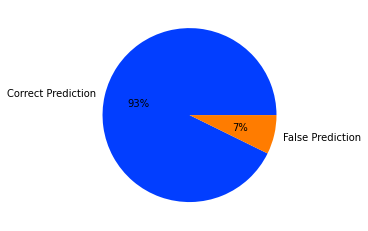

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

#Plot data ke pie chart
data = [correctPrediction, totalData-correctPrediction]
keys = ['Correct Prediction', 'False Prediction']
palette_color = sns.color_palette('bright')
  
plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
plt.show()

In [26]:
#Membuat fungsi untuk melakukan prediksi review sendiri
def prediction (review):
    
    new_review = spark.createDataFrame([(review,0)], 
                                       ["Review","Label"])
    #tokenizier
    tokenizer = Tokenizer(inputCol="Review", outputCol="SentimentWords")
    tokenized = tokenizer.transform(new_review)
    #removing stopword
    swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), 
                       outputCol="MeaningfulWords")
    SwRemoved = swr.transform(tokenized)
    #convert word to numeric
    hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
    numericData = hashTF.transform(SwRemoved).select('MeaningfulWords', 'features')
    #doing a prediction
    prediction = model.transform(numericData)
    predictionFinal = prediction.select("MeaningfulWords", "prediction")
    
    if predictionFinal.collect()[0][1]==1:
        return "Positif"
    else:
        return "Negatif"


#contoh review
review = "tidak suka aplikasinya"

#Melakukan prediksi terhadap review baru
hasil = prediction(review)
print(review,": ",hasil)

22/12/13 14:44:40 WARN StopWordsRemover: Default locale set was [en_ID]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


tidak suka aplikasinya :  Positif


In [58]:
pip install PySastrawi

     |████████████████████████████████| 210 kB 1.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
